# 📗 Restauration d'images

- Correction d'images endommagées
- Suppression de text, logo ou objet d'une image

La reconstruction des parties perdues ou détériorées des images est connue sous le nom de **Inpainting**. 
La reconstruction est censée être effectuée de manière entièrement automatique en exploitant les informations présentées dans les régions non endommagées de l'image.
<br/>
Dans scikit-image, nous pouvons appliquer l'inpainting avec la fonction inpaint biharmonique, depuis le module de restauration. 
Celle-ci a besoin de l'emplacement des pixels endommagés à remplir, sous la forme d'une image masque au-dessus de l'image pour travailler. Une image de masque est simplement une image dont certaines valeurs d'intensité de pixel sont nulles, et d'autres non nulles.

Pour supprimer un objet, nous pouvons le délimiter manuellement dans le **Masque**. 
Si toutefois nous voulons le détecter automatiquement, nous devons utiliser le seuillage ou la segmentation. 
Cela signifie que nous définissons des **masques** pour les zones endommagées de l'image.

### Image reconstruction in scikit-image
```python
from skimage.restoration import inpaint

# Obtention du masque
mask = get_mask(defect_image)

# Application de l'inpainting à l'image endommagée en utilisant le masque
restored_image = inpaint.inpaint_biharmonic(defect_image, mask, multichannel=True)

# Affichage de l'image résultante
show_image(restored_image)
```

### Masque
La fonction d'inpainting de scikit-image requiert que le masque soit un tableau de pixels qui doivent être inpaintés. 
Ce masque doit être de la même forme que l'un des canaux de l'image. Les pixels inconnus doivent être représentés par 1 et les pixels connus par 0. 
Nous ajoutons donc les pixels manquants en copiant l'image et en transformant les pixels en un tableau numpy de zéros, ce qui signifie qu'il est vide. 
Nous ne copions que les dimensions largeur et hauteur de l'image, à l'exclusion de la dimension couleur, dans ce cas RGB-3. 
Ensuite, nous mettons les 1 dans les zones spécifiques que nous voulons traiter comme perdues.

```python
def get_mask(image):
    # Création d'un masque avec trois régions défectueuses
    mask = np.zeros(image.shape[:-1])
    
    mask[20:60, 0:20] = 1
    mask[160:180, 70:155] = 1
    mask[30:60, 170:195] = 1
    mask[-60:-30, 170:195] = 1
    mask[-180:-160, 70:155] = 1
    mask[-60:-20, 0:20] = 1

    # add a few long, narrow defects
    mask[200:205, -200:] = 1
    mask[150:255, 20:23] = 1
    mask[365:368, 60:130] = 1
    return mask
```

### 📝 Restaurons une image endommagée
Dans cet exercice, nous allons restaurer une image qui contient des parties manquantes, en utilisant la fonction <code>inpaint_biharmonic()</code>.

Nous allons travailler sur une image endommagée. Certains pixels ont été remplacés par des 1 à l'aide d'un masque binaire, exprès pour simuler une image endommagée. Le remplacement des pixels par des 1 les rend totalement noirs.

Le masque est une image en noir et blanc avec des patchs qui ont la position des bits d'image qui ont été corrompus. Nous pouvons appliquer la fonction de restauration sur ces zones.

N'oubliez pas que l'inpainting est le processus de reconstruction des parties perdues ou détériorées d'images et de vidéos.

##### Importation du module ou de la bibliothèque nécessaire

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (10, 8)

# Fonction permettant d'afficher une image
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

def plot_comparison(img_original, img_filtered, img_title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.imshow(img_original, cmap=plt.cm.gray)
    ax1.set_title('Originale')
    ax1.axis('off')
    ax2.imshow(img_filtered, cmap=plt.cm.gray)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')


##### Définition de la fonction get_mask() pour obtenir le masque

In [14]:
# Déclaration d'une fonction get_mask() pour le masque
def get_mask(image):
    # Création d'un masque avec trois régions de défaut
    mask = np.zeros(image.shape[:-1], dtype=bool)

    mask[20:60, 0:20] = 1
    mask[160:180, 70:155] = 1
    mask[30:60, 170:195] = 1
    mask[-60:-30, 170:195] = 1
    mask[-180:-160, 70:155] = 1
    mask[-60:-20, 0:20] = 1

    # add a few long, narrow defects
    mask[200:205, -200:] = 1
    mask[150:255, 20:23] = 1
    mask[365:368, 60:130] = 1
    return mask

##### Now inpaint the image

In [15]:
# Importation du module depuis la restauration
from skimage.restoration import inpaint
from skimage.transform import resize
from skimage import color
from skimage import data

image_orig = data.astronaut()

# Obtention du masque
mask = get_mask(image_orig)

defect_image = image_orig * ~mask[..., np.newaxis]

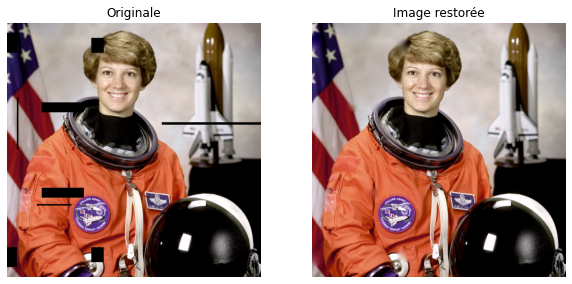

In [16]:
# Application de la fonction de restauration à l'image à l'aide du masque
restored_image = inpaint.inpaint_biharmonic(defect_image, mask, channel_axis=-1)


# Affichage de l'image défectueuse vs restorée
plot_comparison(defect_image, restored_image, 'Image restorée')

<br/> <br/>

# 📗 Bruit
Les images sont des signaux et les signaux du monde réel contiennent généralement des écarts par rapport au signal idéal, qui est l'image parfaite, telle que nous l'observons avec nos yeux dans la vie réelle. 
Ces écarts sont appelés "bruit". 
Nous pouvons voir que cette image présente des grains de couleur lorsqu'elle est agrandie.

Plus précisément, le bruit est le résultat d'erreurs dans le processus d'acquisition de l'image qui se traduisent par des valeurs de pixels qui ne reflètent pas les véritables intensités de la scène réelle. 
Dans cette image, nous pouvons voir comment il y a une variation de luminosité et de couleur qui ne correspond pas à la réalité, qui est produite par la caméra.

<img src="./sampleImages/Chapter3/noise_image.png" center/>

### 📌 Appliquer du bruit dans scikit-image
En utilisant la fonction random_noise, nous obtenons l'image originale avec beaucoup de bruit ajouté, qui est distribué aléatoirement. 
Ce type de bruit est connu sous le nom de "salt and pepper" car c'est en fait ce à quoi il ressemble.

```python
# Import the module and function
from skimage.util import random_noise

# Add noise to the image
noisy_image = random_noise(dog_image)

# Show original and resulting image
show_image(dog_image)
show_image(noisy_image, 'Image bruitée')
```

<img src="data/CM_SampleImages/Chapter3/original_noisy.png" center/>

### 📌 Réduction du bruit
La plupart du temps, nous supprimons ou réduisons le bruit des images au lieu de l'ajouter. 
Pour réduire le bruit d'une image, cela prend du temps en fonction de la résolution de l'image. 
Voici quelques types d'algorithmes de débruitage : 
- Filtre de variation totale (TV)
- Filtre bilatéral
- Débruitage par ondelettes
- Débruitage par moyens non-locaux

#### Débruitage par filtre de variation totale
```python
from skimage.restoration import denoise_tv_chambolle

# Application d'un filtre de variation totale pour le débruitage
denoised_image = denoise_tv_chambolle(noisy_image, weight=0.1, multichannel=True)

# Affichage de l'image bruitée vs débruitée
show_image(noisy_image, 'Image bruitée')
show_image(denoised_image, 'Image débruité')
```

#### Débruitage par filtre bilatérale
```python
from skimage.restoration import denoise_bilateral

# Application d'un filtre bilatérale pour le débruitage
denoised_image = denoise_bilateral(noisy_image, multichannel=True)

# Affichage de l'image bruitée vs débruitée
show_image(noisy_image, 'Image bruitée')
show_image(denoised_image, 'Image débruité')
```

### 📝 "Faites du bruit !"
Dans cet exercice, nous allons nous entraîner à ajouter du bruit à une image de fruit.

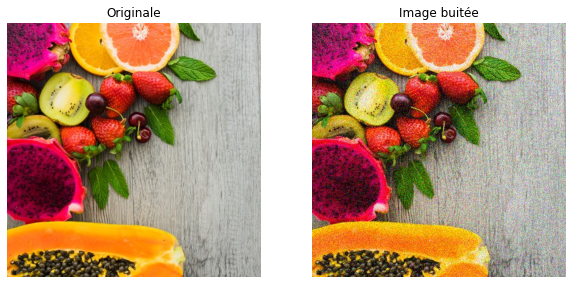

In [17]:
from skimage.util import random_noise

# Chargement de l'image de fruits
fruit_image = plt.imread('data/CM_SampleImages/Chapter3/fruit_image.jpg')

#Ajout de buit à l'image
noisy_image = random_noise(fruit_image)

# Affichage de l'image bruitée vs débruitée
plot_comparison(fruit_image, noisy_image, 'Image buitée')


### 📝 Réduction du bruit
Nous avons une image bruitée que nous voulons améliorer en supprimant le bruit qu'elle contient. Utilisez le débruitage par filtre de variation totale pour y parvenir.

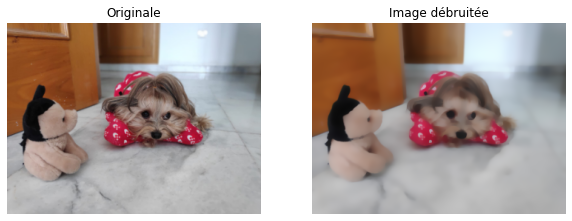

In [18]:
from skimage.restoration import denoise_tv_chambolle

noisy_image = plt.imread('data/CM_SampleImages/Chapter3/cute_noisy_image.png')

# Application d'un filtre de variation totale pour le débruitage
denoised_image = denoise_tv_chambolle(noisy_image, channel_axis=-1)

# Affichage de l'image bruitée vs débruitée
plot_comparison(noisy_image, denoised_image, 'Image débruitée')

### 📝 Réduire le bruit tout en préservant les bords
Dans cet exercice, vous allez réduire le bruit dans cette image de paysage. Comme nous préférons préserver les bords de l'image, nous allons utiliser le filtre de débruitage bilatéral.

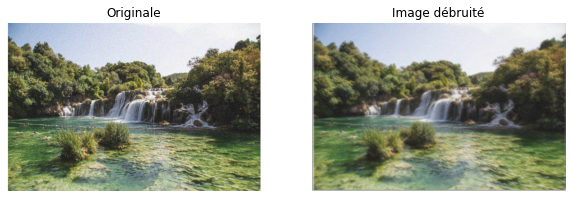

In [19]:
from skimage.restoration import denoise_bilateral

landscape_image = plt.imread('data/CM_SampleImages/Chapter3/landscape_image.png')

# Application d'un filtre bilatérale pour le débruitage
denoised_image = denoise_bilateral(landscape_image, channel_axis=-1)

# Affichage de l'image bruitée vs débruitée
plot_comparison(landscape_image, denoised_image, 'Image débruité')

<br/><br/>

# 📗 Superpixels et segmentation

La segmentation divise les images en régions, ou segments, pour simplifier et/ou modifier la représentation en quelque chose de plus significatif et plus facile à analyser. 
Auparavant, nous avons appris à connaître le seuillage, qui est la méthode de segmentation la plus simple.
Elle sépare le premier plan de l'arrière-plan. Mais la segmentation consiste à séparer plus que cela.

**Pixels:** L'image est représentée par une grille de pixels. 
Mais un seul pixel ne représente pas une chose significative. 
Nous pouvons donc explorer des significations plus logiques dans une image qui est formée de régions plus grandes ou de pixels groupés. 
Ceux-ci sont connus sous le nom de **superpixels**.

## Superpixels
Un superpixel est un groupe de pixels connectés ayant des couleurs ou des niveaux de gris similaires. 
Ils ont plus de signification que leurs homologues de la simple grille de pixels.

<img src="data/CM_SampleImages/Chapter3/superpixels.png" width="400" center/>

La segmentation des superpixels consiste à diviser une image en superpixels. 
Elle a été appliquée à de nombreuses tâches de vision par ordinateur, comme le suivi visuel et la classification d'images. 
Les avantages de leur utilisation sont les suivants : nous pouvons calculer des caractéristiques sur des régions plus significatives. 
Et que nous pouvons réduire une image de milliers de pixels à quelques régions pour les algorithmes ultérieurs, afin d'obtenir une efficacité de calcul.

## Types de segmentation
Il existe deux types de segmentation
- non supervisée (aucune connaissance préalable n'est requise)
- supervisée (certaines connaissances préalables sont utilisées pour guider l'algorithme).


### 📌 Segmentation non supervisée
Une segmentation non supervisée, où aucune connaissance préalable n'est requise. 
Ces algorithmes tentent de subdiviser automatiquement les images en régions significatives. 
L'utilisateur peut toujours modifier certains paramètres pour obtenir le résultat souhaité.

#### Classification linéaire itérative simple (ou SLIC)
Il segmente l'image à l'aide d'un algorithme d'apprentissage automatique appelé clustering K-Means. 
Il prend toutes les valeurs des pixels de l'image et tente de les séparer en un nombre prédéfini de sous-régions.
```python
# Importation des modules
from skimage.segmentation import slic
from skimage.color import label2rgb

# Obtention des segments
segments = segmentation.slic(image)

# Comparaison des segments avec l'image originale
segmented_image = label2rgb(segments, image, kind='avg')

show_image(image)
show_image(segmented_image,"Image segmentée")
```
<br/><br/>

### 📝 Segmentation des superpixels
Dans cet exercice, nous allons appliquer une segmentation non supervisée à la même image, avant de la transmettre à un modèle d'apprentissage automatique de détection des visages.

Vous allez donc réduire cette image de 265×191=50,615 pixels à 400 régions.

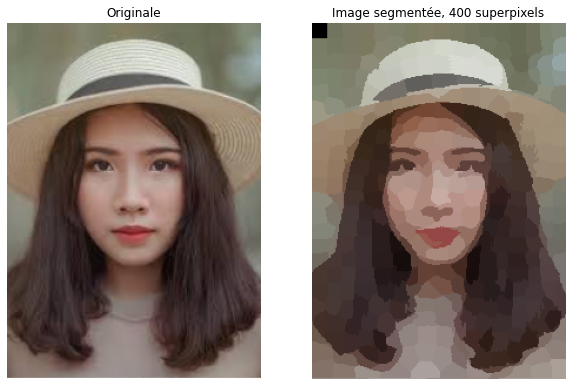

In [21]:
# Importer la fonction slic et label2rgb du module de segmentation
from skimage.segmentation import slic
from skimage.color import label2rgb

face_image = plt.imread('data/CM_SampleImages/Chapter3/face_image.png')
face_image = color.rgba2rgb(face_image)
# Obtenir la segmentation avec 400 régions
segments = slic(face_image, n_segments=400, start_label=0)

# Creation des segments sur l'image originale pour les comparer.
segmented_image = label2rgb(segments, face_image, kind='avg')

plot_comparison(face_image, segmented_image, 'Image segmentée, 400 superpixels')

<br/><br/>

# 📗 Trouver des contours
Un **contour** est une forme fermée de points ou de segments de ligne, représentant les limites de ces objets. Trouver des contours signifie
- Mesurer la taille
- Classifier des formes
- Déterminer le nombre d'objets

L'entrée d'une fonction de recherche de contours doit être une image binaire, que nous pouvons produire en appliquant d'abord un seuillage. Dans cette image binaire, les objets que nous souhaitons détecter doivent être blancs, tandis que l'arrière-plan reste noir.

### 📌 Trouver des contours avec scikit-image

**PREPARATION DE L'IMAGE**

* RGB vers monochrome.
```python
image = color.rgb2gray(image)
```
* Binarization

```python
# Obtention de la valeur seuil
thresh = threshold_otsu(image)
# Application du seuil
thresholded_image = image > thresh
```

**ON UTILISE ENSUITE <code>find_contours()</code>**

```python
# Importation du module measure
from skimage import measure

# Trouver les contours à une valeur constante de 0,8
contours = measure.find_contours(thresholded_image, 0.8)
```
<br/>

### 📝 Contours des formes
Dans cet exercice, nous allons trouver le contour d'un cheval.

Pour cela, nous allons utiliser une image binarisée fournie par scikit-image dans son module de données. Les images binarisées sont plus faciles à traiter lors de la recherche de contours avec cet algorithme. N'oubliez pas que la recherche de contours ne prend en charge que les tableaux d'images 2D.

Une fois le contour détecté, nous l'affichons avec l'image originale. De cette façon, nous pouvons vérifier si notre analyse était correcte !

In [22]:
def show_image_contours(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=3)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')

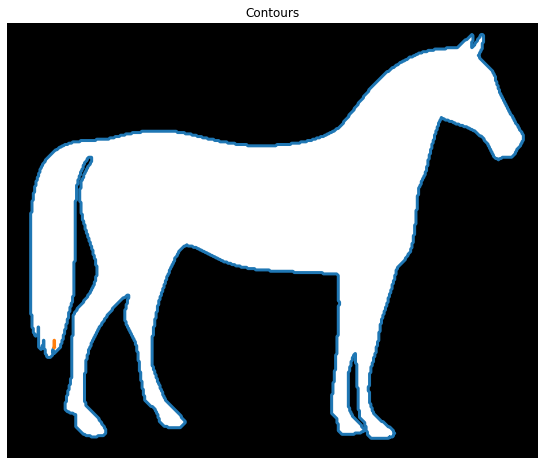

In [23]:
from skimage import measure, data

# Obtention de l'image du cheval
horse_image = data.horse()

# On trouve les contours à une valeur constante de 0,8
contours = measure.find_contours(horse_image, level=0.8)

# Affichage des contours trouvés
show_image_contours(horse_image, contours)

<br/><br/>

### 📝 Trouver les contours d'une image qui n'est pas binaire
Travaillons un peu plus sur la façon de préparer une image pour pouvoir trouver ses contours et en extraire des informations.
Nous allons traiter une image de deux dés violets chargés en tant qu'image_dices et déterminer quel chiffre a été obtenu pour chaque dé.

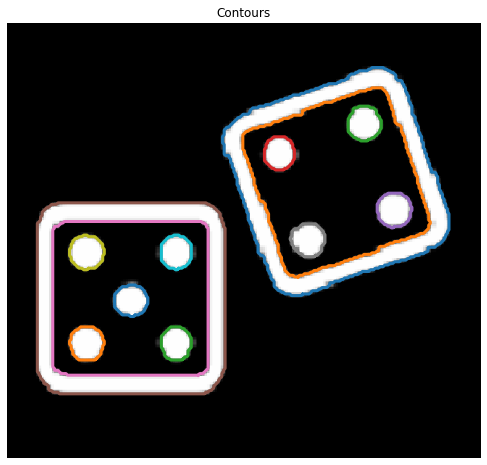

In [24]:
from skimage.filters import threshold_otsu

image_dices = plt.imread('data/CM_SampleImages/Chapter3/dice.png')

# RGB vers monochrome
image_dices = color.rgb2gray(color.rgba2rgb(image_dices))

# Obtention de la valeur seuil pour binarization
thresh = threshold_otsu(image_dices)

# Binarization
binary = image_dices > thresh

# On trouve les contours à une valeur constante de 0,8
contours = measure.find_contours(binary, level=0.8)

# Affichage de l'image
show_image_contours(image_dices, contours)

<br/><br/>

### 📝 Comptage des points dans l'image d'un dé
Maintenant que nous avons trouvé les contours, nous pouvons en extraire des informations.

Dans l'exercice précédent, nous avons préparé une image de dé violet pour en trouver les contours :

Cette fois, nous allons déterminer quel numéro a été lancé pour le dé, en comptant les points dans l'image.

Créez une liste avec toutes les formes des contours comme shape_contours. Vous pouvez voir toutes les formes des contours en appelant shape_contours dans la console, une fois que vous l'avez créée.

Vérifiez que la plupart des contours n'ont pas une taille supérieure à 50. Si vous les comptez, ils correspondent au nombre exact de points dans l'image.

Affichage du numéro obtenue: 9.


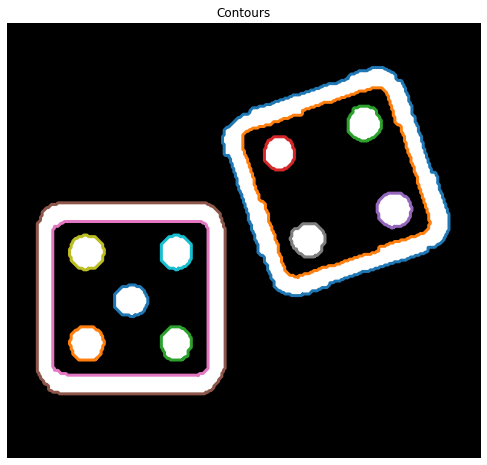

In [25]:
shape_contours = [cnt.shape[0] for cnt in contours]

# Définir 90 comme la taille maximale de la forme des points.
max_dots_shape = 90

# Compte les points dans les contours, à l'exception de ceux dont la taille est supérieure à celle des points.
dots_contours = [cnt for cnt in contours if np.shape(cnt)[0] < max_dots_shape]

# Affiche tous les contours trouvés
show_image_contours(binary, contours)

# Affichage du numéro obtenue
print('Affichage du numéro obtenue: {}.'.format(len(dots_contours)))